In [300]:
import os
import math
import time
import pickle
import json
import spacy
import requests
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('colorblind', 20, 0.75)
from time import sleep
import matplotlib.pyplot as plt
import matplotlib as mpl
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# plt.style.use('fivethirtyeight')
%matplotlib inline
mpl.rc('font', size=16)
mpl.rc('xtick', labelsize=14)     
mpl.rc('ytick', labelsize=14)


In [205]:
def save_file(obj, name) :
    '''
        Function to save data as pickle file
    '''
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_file(name):
    '''
        Function to load data from pickle file
    '''
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### Load and clean data

In [206]:
col_names = ['Id', 'label', 'statement', 'subjects', 'speaker', 'job_title', 'state', 'party', 'barely_true', 
             'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']
train_path = './data/train.tsv'
valid_path = './data/valid.tsv'
test_path = './data/test.tsv'
news_train = pd.read_csv(train_path, sep="\t", header=None, names=col_names, na_values=['none', 'None'])
news_valid = pd.read_csv(valid_path, sep="\t", header=None, names=col_names, na_values=['none', 'None'])
news_test = pd.read_csv(test_path, sep="\t", header=None, names=col_names, na_values=['none', 'None'])

In [207]:
news_train.sample(3)

,Id,label,statement,subjects,speaker,job_title,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
8156,12731.json,barely-true,A million Democrats deserted (Howard Deans) pa...,economy,hugh-hewitt,NaN,NaN,republican,1.0,0.0,1.0,0.0,0.0,an MSNBC panel
9667,10074.json,mostly-true,Raising the minimum wage to $10.10 an hour wil...,"income,jobs,message-machine-2014",mitch-mcconnell,Senate minority leader,Kentucky,republican,7.0,6.0,5.0,7.0,0.0,a debate
6339,5863.json,barely-true,Says I never billed a single hour of my time t...,"city-government,ethics,message-machine-2012",charlie-hales,"Senior vice president, HDR Engineering",Oregon,NaN,1.0,1.0,0.0,0.0,0.0,a debate


In [208]:
news_train.shape

(10240, 14)

In [209]:
news_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
Id               10240 non-null object
label            10240 non-null object
statement        10240 non-null object
subjects         10238 non-null object
speaker          10238 non-null object
job_title        7340 non-null object
state            8030 non-null object
party            8494 non-null object
barely_true      10238 non-null float64
false            10238 non-null float64
half_true        10238 non-null float64
mostly_true      10238 non-null float64
pants_on_fire    10238 non-null float64
context          10138 non-null object
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [210]:
# Remove Id column
news_train.drop('Id', axis=1, inplace=True)

In [211]:
news_train[news_train.subjects.isnull()]

,label,statement,subjects,speaker,job_title,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
2142,false,The fact is that although we have had a presid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9375,false,"Joe, I keep hearing you every morning talking ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
# Remove the 2 rows that have no meta data
news_train = news_train[~news_train.subjects.isnull()]

In [213]:
news_train.label.unique() # all the labels belong to one of the six classes

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [214]:
subjects_list = []
for subj in news_train.subjects:
    subjects_list.extend(subj.split(','))
unique_subjects = set(subjects_list)
print ('number of subjects:', len(unique_subjects))
print (unique_subjects)

number of subjects: 142
{'fires', 'sexuality', 'cap-and-trade', 'new-hampshire-2012', 'deficit', 'bipartisanship', 'human-rights', 'abortion', 'social-security', '10-news-tampa-bay', 'occupy-wall-street', 'city-budget', 'tourism', 'afghanistan', 'housing', 'diversity', 'oil-spill', 'civil-rights', 'homeland-security', 'pensions', 'technology', 'city-government', 'debt', 'abc-news-week', 'pundits', 'retirement', 'foreign-policy', 'privacy', 'financial-regulation', 'county-government', 'state-finances', 'medicare', 'marijuana', 'obama-birth-certificate', 'climate-change', 'federal-budget', 'transparency', 'women', 'polls', 'campaign-finance', 'fake-news', 'marriage', 'legal-issues', 'congressional-rules', 'food-safety', 'drugs', 'death-penalty', 'agriculture', 'water', 'disability', 'government-efficiency', 'weather', 'pop-culture', 'census', 'transportation', 'israel', 'florida-amendments', 'message-machine-2014', 'nuclear', 'gas-prices', 'lottery', 'debates', 'consumer-safety', 'histor

In [215]:
news_train.party.unique()

array(['republican', 'democrat', nan, 'organization', 'independent',
       'columnist', 'activist', 'talk-show-host', 'libertarian',
       'newsmaker', 'journalist', 'labor-leader', 'state-official',
       'business-leader', 'education-official', 'tea-party-member',
       'green', 'liberal-party-canada', 'government-body', 'Moderate',
       'democratic-farmer-labor', 'ocean-state-tea-party-action',
       'constitution-party'], dtype=object)

In [216]:
# replace missing values with 'NA'
news_train.loc[news_train.party.isnull(),'party'] = 'NA'
news_train.loc[news_train.job_title.isnull(),'job_title'] = 'NA'
news_train.loc[news_train.context.isnull(),'context'] = 'NA'
news_train.loc[news_train.state.isnull(),'state'] = 'NA'

In [217]:
# remove leading and trailing whitespace
news_train["state"] = news_train["state"].map(str.strip)
news_train.state.unique()

array(['Texas', 'Virginia', 'Illinois', 'NA', 'Florida', 'Wisconsin',
       'New Jersey', 'Vermont', 'Massachusetts', 'Maryland',
       'Washington, D.C.', 'Oregon', 'New York', 'California', 'Missouri',
       'Rhode Island', 'West Virginia', 'Arkansas', 'New Hampshire',
       'Ohio', 'Georgia', 'Arizona', 'Wyoming', 'Delaware', 'Kentucky',
       'Kansas', 'ohio', 'Colorado', 'North Carolina', 'New Mexico',
       'Alaska', 'South Carolina', 'Minnesota', 'Tennessee',
       'Pennsylvania', 'Iowa', 'Connecticut', 'Louisiana', 'Indiana',
       'Utah', 'Michigan', 'Oklahoma', 'Nevada', 'Virgina', 'Nebraska',
       'Washington D.C.', 'Alabama', 'Russia', 'Washington state',
       'Washington', 'District of Columbia', 'Unknown', 'Mississippi',
       'Rhode island', 'China', 'United Kingdom', 'South Dakota', 'Qatar',
       'Montana', 'North Dakota', 'Idaho', 'Maine',
       'Virginia director, Coalition to Stop Gun Violence', 'Virgiia',
       'Hawaii', 'Atlanta', 'Tennesse', 'Wash

In [218]:
# clean the state column for training data
news_train.loc[news_train.state == 'Unknown','state'] = 'NA'
news_train.loc[news_train.state == 'PA - Pennsylvania','state'] = 'Pennsylvania'
news_train.loc[news_train.state == 'Virgiia','state'] = 'Virginia'
news_train.loc[news_train.state == 'Virginia director, Coalition to Stop Gun Violence','job_title'] = 'Virginia director, Coalition to Stop Gun Violence'
news_train.loc[news_train.state == 'Virginia director, Coalition to Stop Gun Violence','state'] = 'Virginia'
news_train.loc[news_train.state == 'Virgina','state'] = 'Virginia'
news_train.loc[news_train.state == 'Tex','state'] = 'Texas'
news_train.loc[news_train.state == 'Washington, D.C.','state'] = 'Washington DC'
news_train.loc[news_train.state == 'Washington D.C.','state'] = 'Washington DC'
news_train.loc[news_train.state == 'District of Columbia','state'] = 'Washington DC'
news_train.loc[news_train.state == 'Washington state','state'] = 'Washington'
news_train.loc[news_train.state == 'Rhode island','state'] = 'Rhode Island'
news_train.loc[news_train.state == 'ohio','state'] = 'Ohio'

In [220]:
# clean validation data
news_valid.loc[news_valid.party.isnull(),'party'] = 'NA'
news_valid.loc[news_valid.job_title.isnull(),'job_title'] = 'NA'
news_valid.loc[news_valid.context.isnull(),'context'] = 'NA'
news_valid.loc[news_valid.state.isnull(),'state'] = 'NA'

In [221]:
# clean the state column for validation data
news_valid["state"] = news_valid["state"].map(str.strip)
news_valid.loc[news_valid.state == 'District of Columbia','state'] = 'Washington DC'
news_valid.loc[news_valid.state == 'Washington, D.C.','state'] = 'Washington DC'
news_valid.loc[news_valid.state == 'ohio','state'] = 'Ohio'
print (news_valid.state.unique())

['Missouri' 'NA' 'Oregon' 'Illinois' 'New Hampshire' 'Tennessee'
 'New York' 'Texas' 'Virginia' 'Georgia' 'Delaware' 'Washington DC'
 'Rhode Island' 'Florida' 'Wisconsin' 'Arizona' 'Massachusetts' 'Ohio'
 'South Carolina' 'New Jersey' 'California' 'Pennsylvania' 'Russia'
 'Kentucky' 'Louisiana' 'New Mexico' 'Colorado' 'Vermont' 'Minnesota'
 'Arkansas' 'Michigan' 'Maryland' 'Oklahoma' 'Iowa' 'Utah' 'Indiana'
 'North Carolina' 'Alaska' 'Washington' 'Nevada' 'Connecticut'
 'North Dakota' 'Kansas' 'Alabama' 'West Virginia']


In [223]:
# clean test data
news_test.loc[news_test.party.isnull(),'party'] = 'NA'
news_test.loc[news_test.job_title.isnull(),'job_title'] = 'NA'
news_test.loc[news_test.context.isnull(),'context'] = 'NA'
news_test.loc[news_test.state.isnull(),'state'] = 'NA'

In [224]:
# clean the state column for test data
news_test["state"] = news_test["state"].map(str.strip)
news_test.loc[news_test.state == 'District of Columbia','state'] = 'Washington DC'
news_test.loc[news_test.state == 'Washington, D.C.','state'] = 'Washington DC'
news_test.loc[news_test.state == 'Washington D.C.','state'] = 'Washington DC'
news_test.loc[news_test.state == 'ohio','state'] = 'Ohio'
news_test.loc[news_test.state == 'Unknown','state'] = 'NA'

print (news_test.state.unique())

['Texas' 'Wisconsin' 'New York' 'Oregon' 'Rhode Island' 'Tennessee' 'Ohio'
 'Indiana' 'Georgia' 'NA' 'Pennsylvania' 'Alaska' 'North Carolina'
 'Florida' 'South Carolina' 'Colorado' 'Illinois' 'Virginia'
 'New Hampshire' 'Massachusetts' 'Minnesota' 'New Jersey' 'Arizona'
 'Delaware' 'New Mexico' 'Washington DC' 'Kentucky' 'Utah' 'Vermont'
 'Missouri' 'West Virginia' 'California' 'Maryland' 'Connecticut'
 'South Dakota' 'Nevada' 'Alabama' 'Michigan' 'Louisiana' 'Iowa'
 'Arkansas' 'Washington' 'Kansas']


**Take a look at some examples in each class**

In [225]:
news_train[news_train.label == 'pants-fire']['statement'].iloc[0]

'In the case of a catastrophic event, the Atlanta-area offices of the Centers for Disease Control and Prevention will self-destruct.'

In [226]:
news_train[news_train.label == 'false']['statement'].iloc[0]

'Says the Annies List political group supports third-trimester abortions on demand.'

In [227]:
news_train[news_train.label == 'barely-true']['statement'].iloc[0]

'Jim Dunnam has not lived in the district he represents for years now.'

In [228]:
news_train[news_train.label == 'half-true']['statement'].iloc[0]

'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'

In [229]:
news_train[news_train.label == 'mostly-true']['statement'].iloc[0]

'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."'

In [230]:
news_train[news_train.label == 'true']['statement'].iloc[0]

'The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.'

### EDA & Feature engineering

I do not need the granularity of the 6 classes, hence I am combining them into 3 classes.

In [231]:
# combine the 6 classes into 3 classes
news_train['grouped_label'] = ['false' if value in ['pants-fire', 'false'] else 'half-true' if value in ['barely-true', 'half-true'] else 'true' for value in news_train['label']]
news_valid['grouped_label'] = ['false' if value in ['pants-fire', 'false'] else 'half-true' if value in ['barely-true', 'half-true'] else 'true' for value in news_valid['label']]
news_test['grouped_label'] = ['false' if value in ['pants-fire', 'false'] else 'half-true' if value in ['barely-true', 'half-true'] else 'true' for value in news_test['label']]


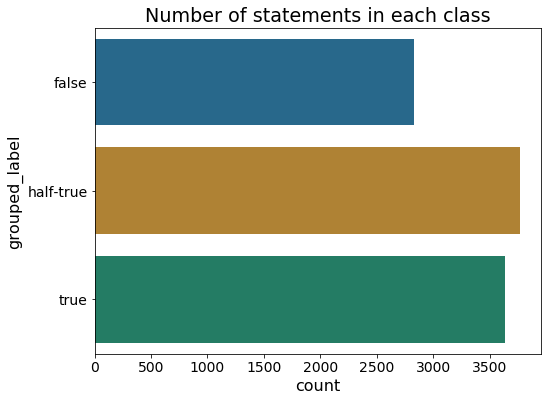

In [232]:
# distribution of classes
plt.figure(figsize=(8,6))
sns.countplot(y="grouped_label", data=news_train)
plt.title('Number of statements in each class')
plt.show()

**Statement length**

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


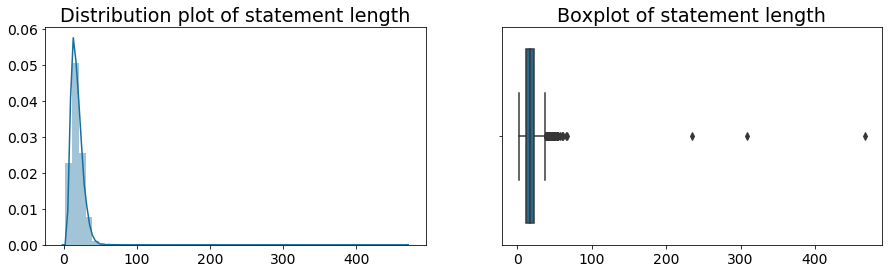

In [233]:
# length of statement
statement_length = [len(x.split()) for x in news_train['statement']]
plt.figure(figsize=(15,4))
plt.subplot(121)
sns.distplot(statement_length)
plt.title('Distribution plot of statement length')
plt.subplot(122)
sns.boxplot(statement_length)
plt.title('Boxplot of statement length')
plt.show()

In [234]:
news_train['statement_length'] = statement_length

The distribution of statement length in each class looks rather similar. Might not be a good predictor for the classifier.

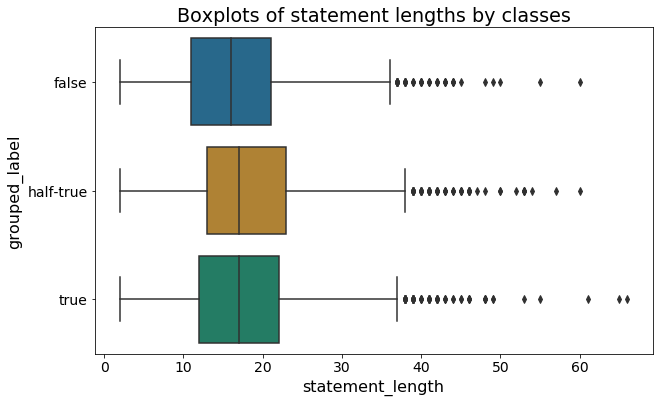

In [235]:
plt.figure(figsize=(10,6))
sns.boxplot(x='statement_length', y='grouped_label', data=news_train[news_train['statement_length']<200])
plt.title('Boxplots of statement lengths by classes')
plt.show()

**Unique words**

In [236]:
# number of unique words in the statement
news_train['unique_words'] = [len(np.unique(value.split())) for value in news_train.statement]

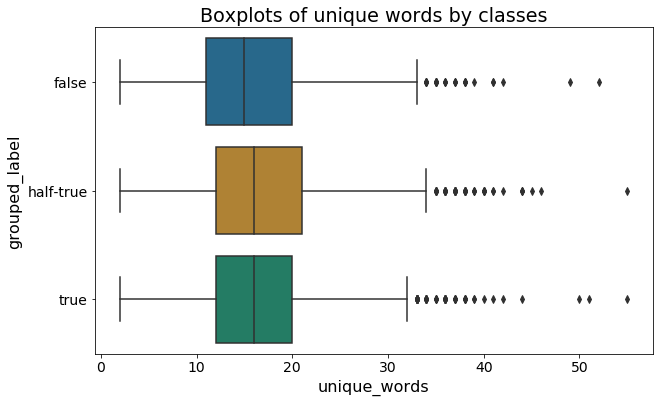

In [237]:
plt.figure(figsize=(10,6))
sns.boxplot(x='unique_words', y='grouped_label', data=news_train[news_train['statement_length']<150])
plt.title('Boxplots of unique words by classes')
plt.show()

**Proportion of Part of Speech**

In [238]:
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [239]:
# parsing each statement
parsed_statement = []
for i, parsed in enumerate(nlp.pipe(news_train.statement.values, batch_size=50, n_threads=4)):
    assert parsed.is_parsed
    if (i % 1000) == 0:
        print(i)
    parsed_statement.append(parsed)   

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [240]:
# # get the unique parts of speech
# unique_pos = []
# for parsed in parsed_statement:
#     unique_pos.extend([t.pos_ for t in parsed])
# unique_pos = np.unique(unique_pos)
# print(unique_pos)

In [241]:
unique_pos = ['ADJ', 'ADP', 'ADV', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
 'PUNCT', 'SPACE', 'SYM', 'VERB', 'X']

In [242]:
# initialize the parts of speech columns
for pos in unique_pos:
    news_train[pos+'_prop'] = 0.

In [243]:
# calculate the proportion of each POS in the statement
news_train = news_train.reset_index(drop=True)
for i, parsed in enumerate(parsed_statement):
    if (i % 100) == 0:
        print(i, end=' ')
    parsed_len = len(parsed)
    for pos in unique_pos:
        count = len([token for token in parsed if token.pos_ == pos])
        news_train.loc[i, pos+'_prop'] = float(count)/parsed_len

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 

It seems like the false statements have a slightly higher proportion of VERBs and PROPNs.

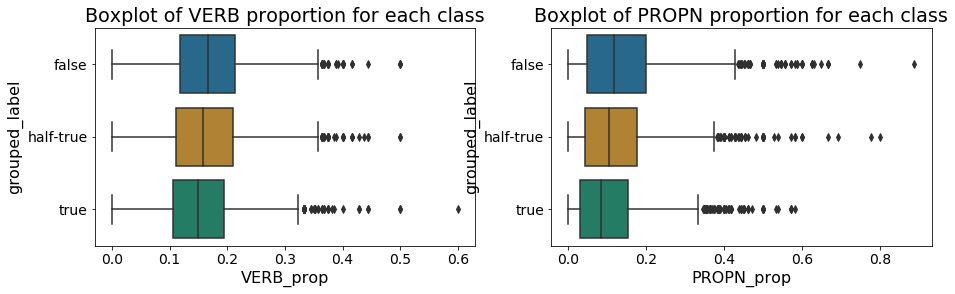

In [244]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sns.boxplot(x='VERB_prop', y='grouped_label', data=news_train)
plt.title('Boxplot of VERB proportion for each class')
plt.subplot(122)
sns.boxplot(x='PROPN_prop', y='grouped_label', data=news_train)
plt.title('Boxplot of PROPN proportion for each class')

plt.show()

**Parse tree depth**

In [245]:
# initialize tree depth column
news_train['tree_depth'] = 0

In [246]:
# recursive function to find the depth of a parse tree generated from a sentence
def get_depth(token, depth=0):
    try:
        return max(get_depth(child, depth+1) for child in token.children) # tranverse the depth of the tree
    except:
        return depth # return depth if it is a leaf node

In [247]:
# calculate the average tree depth of a statement by averaging the tree depth of multiple sentences in a statement
def calc_avg_depth(row):
    doc = nlp(row.statement)
    root_words = []
    for sentence in doc.sents:
        root_words.append(sentence.root) # find the root word of each sentence
    depths = []
    for token in doc:
        if token in root_words:
            depths.append(get_depth(token)) # find the tree depth starting from the root word
    row['tree_depth'] = np.mean(depths) # find the average tree depth
    return row

In [248]:
news_train = news_train.apply(calc_avg_depth,axis=1)

It seems like the distributions of the tree depth for each class are similar. It might not be a good predictor for the classifier.

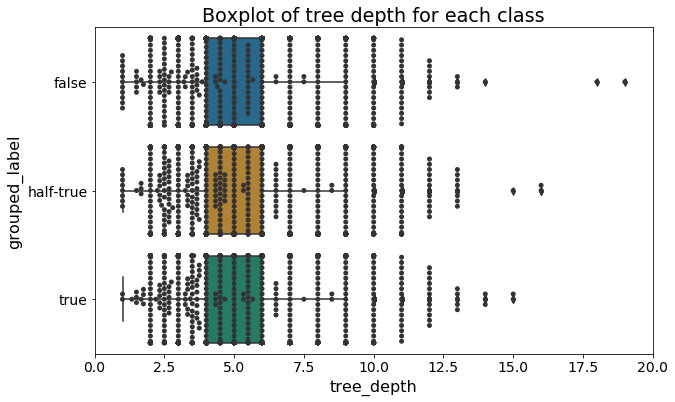

In [249]:
plt.figure(figsize=(10,6))
sns.boxplot(x='tree_depth', y='grouped_label', data=news_train)
sns.swarmplot(x='tree_depth', y='grouped_label', data=news_train, color=".2")
plt.title('Boxplot of tree depth for each class')

plt.show()

**Sentiment of statement**

In [250]:
# find the sentiment for each statement using VADER
analyzer = SentimentIntensityAnalyzer()
news_train['vader_neg'] = 0
news_train['vader_pos'] = 0
news_train['vader_neu'] = 0
news_train['vader_compound'] = 0

for i, s in enumerate(news_train.statement):
    vs = analyzer.polarity_scores(s)
    news_train.iloc[i, -4] = vs['neg']
    news_train.iloc[i, -3] = vs['pos']
    news_train.iloc[i, -2] = vs['neu']
    news_train.iloc[i, -1] = vs['compound']

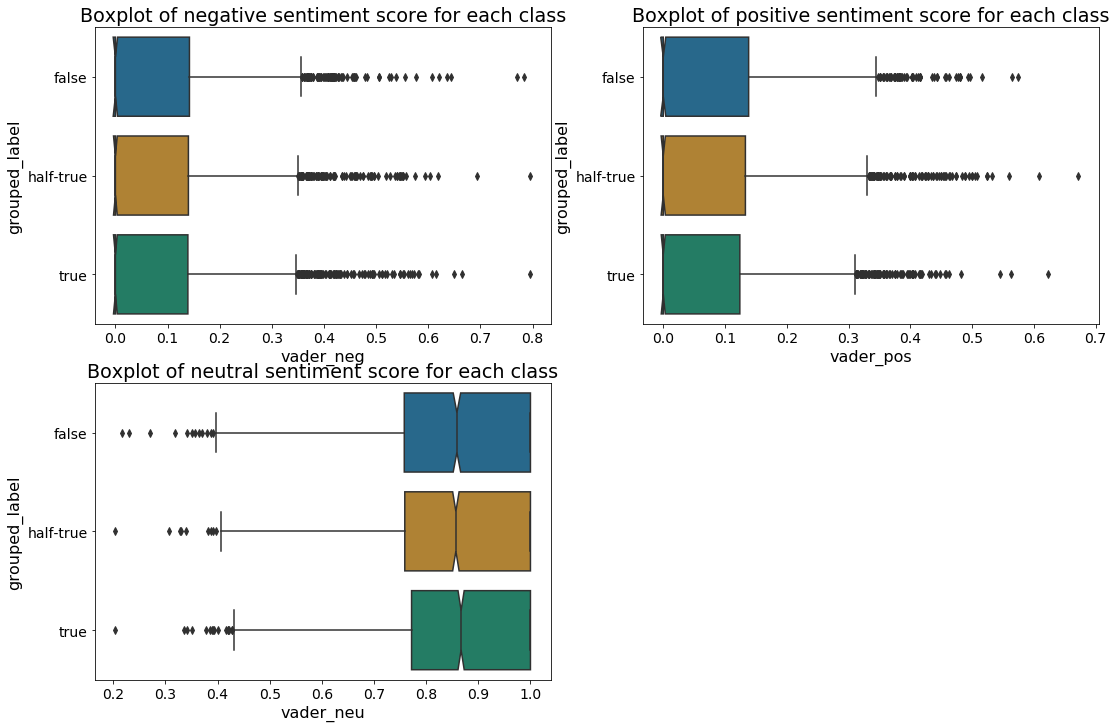

In [251]:
plt.figure(figsize=(18,12))
plt.subplot(221)
sns.boxplot(x='vader_neg', y='grouped_label', data=news_train, notch=True)
plt.title('Boxplot of negative sentiment score for each class')
plt.subplot(222)
sns.boxplot(x='vader_pos', y='grouped_label', data=news_train, notch=True)
plt.title('Boxplot of positive sentiment score for each class')
plt.subplot(223)
sns.boxplot(x='vader_neu', y='grouped_label', data=news_train, notch=True)
plt.title('Boxplot of neutral sentiment score for each class')
plt.show()

**Subject of statement**

In [252]:
for subj in unique_subjects:
    news_train['subj_' + subj] = 0

In [253]:
# dummify the subjects column
for i, subj in enumerate(news_train.subjects):
    subjects = subj.split(',')
    for subject in subjects:
        news_train.loc[i, 'subj_'+subject] = 1

In [254]:
subject_cols = [col for col in news_train.columns if col.startswith('subj_')]
subjects_count = news_train.groupby('grouped_label').sum()[subject_cols]

In [255]:
order_of_labels = ['false', 'half-true', 'true']

In [256]:
def calc_proportion(row):
    return row / np.sum(row)

In [257]:
subjects_proportion = subjects_count.apply(calc_proportion,axis=1)

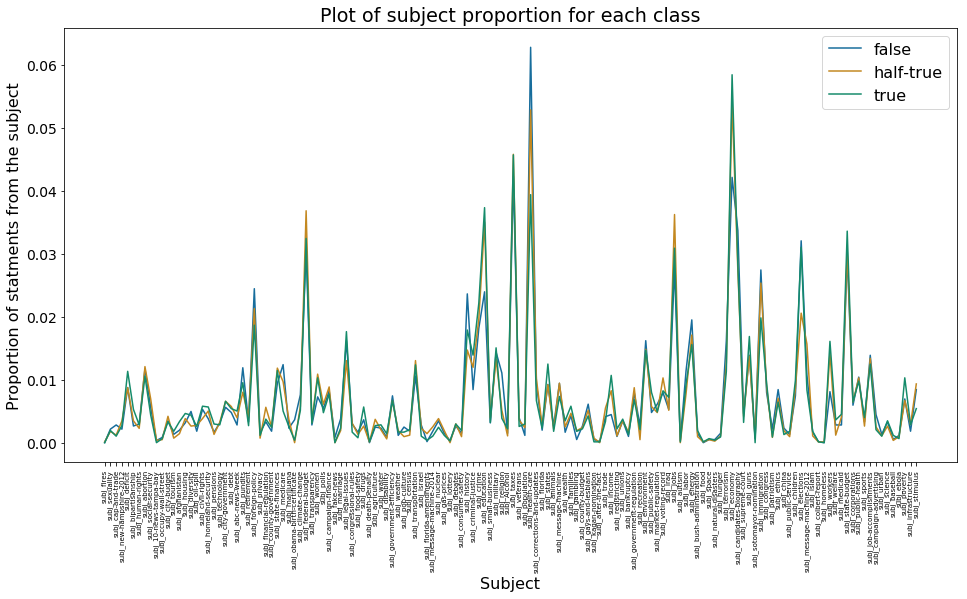

In [258]:
plt.figure(figsize=(16,8))
for lab in order_of_labels:
    plt.plot(subject_cols, subjects_proportion.loc[lab, :], label=lab, linewidth=1.5)
plt.legend()
plt.title('Plot of subject proportion for each class')
plt.ylabel('Proportion of statments from the subject')
plt.xlabel('Subject')
plt.xticks(fontsize=7, rotation=90)
plt.show()

**Party affiliation**

In [259]:
# dummify the party affliation column
news_train = pd.concat([news_train, pd.get_dummies(news_train.party, prefix='party')], axis=1)

In [260]:
party_cols = [col for col in news_train.columns if col.startswith('party_')]
party_count = news_train.groupby('grouped_label').sum()[party_cols]

In [264]:
party_proportion = party_count.apply(calc_proportion,axis=1).reset_index()

It seems like the Republicans contribute to a larger proportion of the false and half-true statements as compared to the Democrats. This could be a good predictor for the classifier.

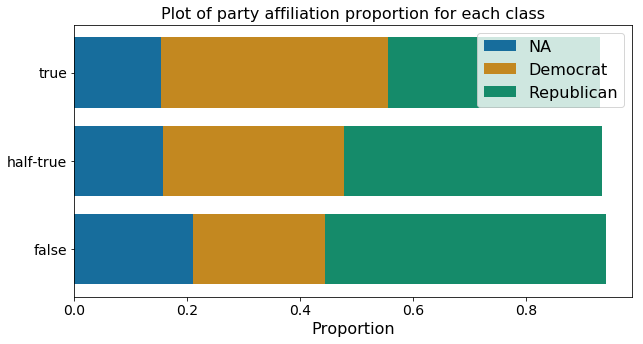

In [267]:
plt.figure(figsize=(10,5))
plt.barh(y=party_proportion['grouped_label'], width=party_proportion['party_NA'], label='NA')
plt.barh(y=party_proportion['grouped_label'], width=party_proportion['party_democrat'], 
             left=party_proportion['party_NA'], label='Democrat')
plt.barh(y=party_proportion['grouped_label'], width=party_proportion['party_republican'], 
             left=party_proportion['party_NA']+party_proportion['party_democrat'], label='Republican')
plt.title('Plot of party affiliation proportion for each class', fontsize=16)
plt.xlabel('Proportion', fontsize=16)
plt.legend()
plt.show()

**State**

In [268]:
# dummify the state column
news_train = pd.concat([news_train, pd.get_dummies(news_train.state, prefix='state')], axis=1)

Looks like state_NA (for speakers like facebook postings) contributes relatively more to the false statements. The state of Ohio also contributes relatively more to the true statements.

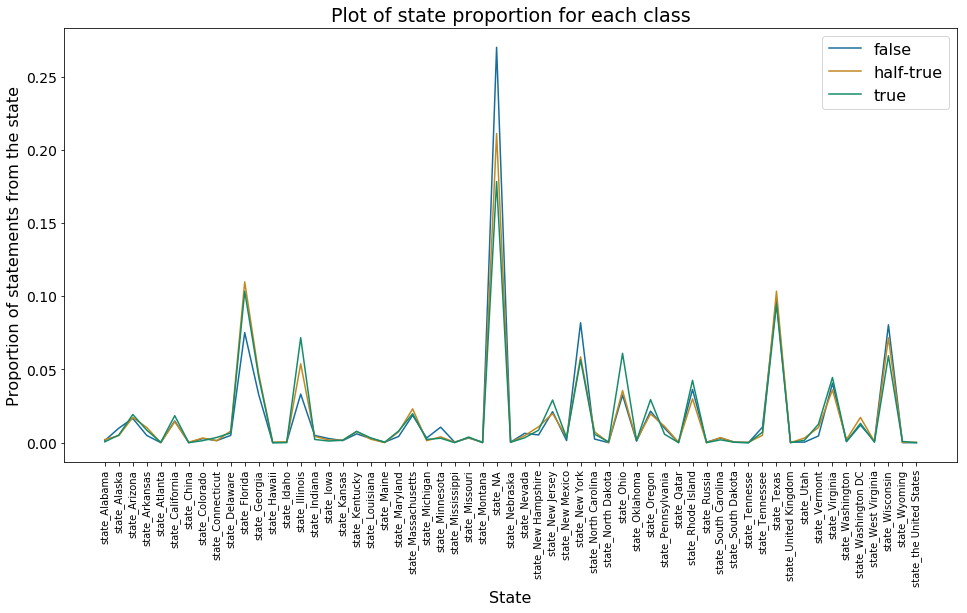

In [269]:
state_cols = [col for col in news_train.columns if col.startswith('state_')]
state_count = news_train.groupby('grouped_label').sum()[state_cols]
state_proportion = state_count.apply(calc_proportion,axis=1)
plt.figure(figsize=(16,8))
for lab in order_of_labels:
    plt.plot(state_cols, state_proportion.loc[lab, :], label=lab, linewidth=1.5)
plt.legend()
plt.title('Plot of state proportion for each class')
plt.ylabel('Proportion of statements from the state')
plt.xlabel('State')
plt.xticks(fontsize=10, rotation=90)
plt.show()

In [270]:
top_speakers = news_train.speaker.value_counts()[0:10]
speaker_label_list = []
for speaker in top_speakers.index:
    speaker_label_list.append(news_train.loc[news_train.speaker == speaker]['label'].value_counts().to_dict())
speaker_label_count = pd.DataFrame(speaker_label_list)
speaker_label_proportion = speaker_label_count.apply(calc_proportion,axis=1)

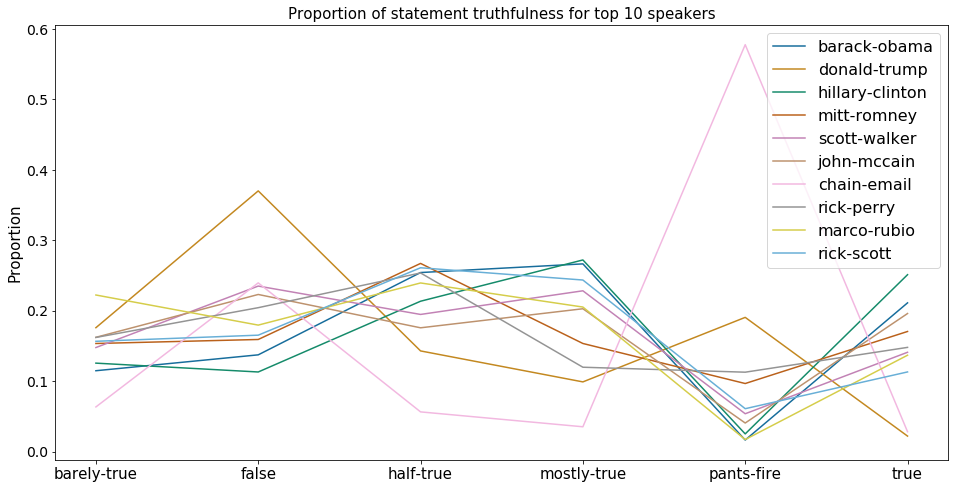

In [271]:
plt.figure(figsize=(16,8))
for i, speaker in enumerate(top_speakers.index):
    sns.lineplot(speaker_label_proportion.columns, speaker_label_proportion.loc[i, :], label=speaker, linewidth=1.5)
plt.legend()
plt.title('Proportion of statement truthfulness for top 10 speakers', fontsize=15)
plt.ylabel('Proportion', fontsize=15)
plt.xticks(fontsize=15, rotation=0)
plt.show()

**Bag of Words from the statement**

In [281]:
stopword_list = stopwords.words('english')

# remove negation terms
stopword_list.remove('no')
stopword_list.remove('not')

In [273]:
def plot_freq_words(word_counts):
    word_counts_grouped = word_counts.groupby('grouped_label').sum().T
    false_counts = word_counts_grouped['false'].sort_values(ascending=False)
    half_true_counts = word_counts_grouped['half-true'].sort_values(ascending=False)
    true_counts = word_counts_grouped['true'].sort_values(ascending=False)
    plt.figure(figsize=(16,8))
    plt.subplot(131)
    sns.barplot(x=false_counts.values[0:20], y=false_counts.index[0:20])
    plt.title("False statements")
    plt.xlabel('frequency')
    plt.subplot(132)
    sns.barplot(x=half_true_counts.values[0:20], y=half_true_counts.index[0:20])
    plt.title("Half true statements")
    plt.xlabel('frequency')
    plt.subplot(133)
    sns.barplot(x=true_counts.values[0:20], y=true_counts.index[0:20])
    plt.title("True statements")
    plt.xlabel('frequency')
    plt.show()

In [274]:
cvt = CountVectorizer(stop_words=stopword_list, ngram_range=(2,2))
counts = cvt.fit_transform(news_train['statement'])

(10238, 73460)


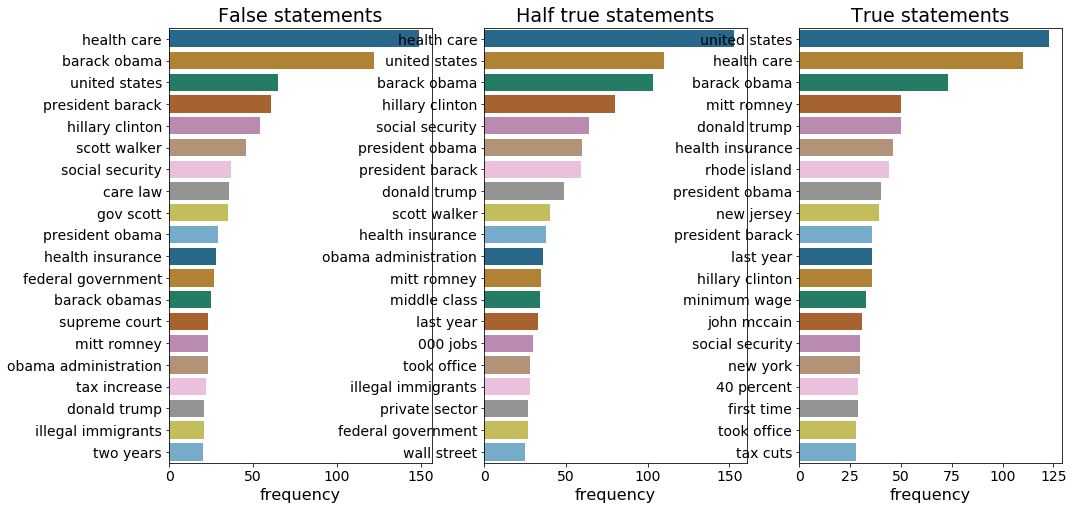

In [275]:
statement_counts = pd.DataFrame(counts.toarray(), columns=cvt.get_feature_names())
print (statement_counts.shape)
statement_counts['grouped_label'] = news_train['grouped_label']
plot_freq_words(statement_counts)

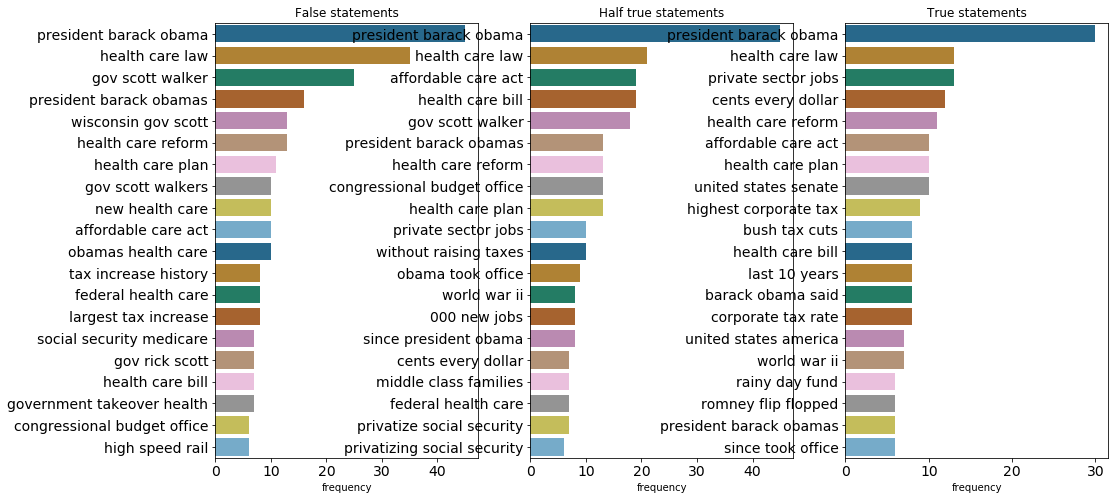

In [139]:
cvt = CountVectorizer(stop_words=stopword_list, ngram_range=(3,3))
counts = cvt.fit_transform(news_train['statement'])
statement_counts = pd.DataFrame(counts.toarray(), columns=cvt.get_feature_names())
statement_counts['grouped_label'] = news_train['grouped_label']
plot_freq_words(statement_counts)

### Modeling using BOW from statement

In [276]:
def train_validate(pipeline, X_train, y_train, X_valid, y_valid):
    '''
        Function to fit and score the model
    '''
    try:
        pipeline.fit(X_train, y_train)
        return pipeline.score(X_valid, y_valid)
    except ValueError:
        return

In [277]:
def best_params(model_list):
    '''
        Function that returns the best parameters for the model with best mean score
    '''
    sorted_list = sorted(model_list, key=lambda k: -k['score']) 
    return sorted_list[0]

In [278]:
def grid_search(model, param_grid, X_train, y_train, X_valid, y_valid, X_test, y_test, is_pipeline=True, verbose=True):
    '''
        Function to search through models with different parameters
        
        Paramters
        ----------
        model: Object. Can be a pipeline or callable
        param_grid: dictionary of parameter values
        X_train: DataFrame
            Training design matrix 
        y_train: Series
            Training dataset labels
        X_valid: DataFrame
            Validation design matrix 
        y_valid: Series
            Valiation dataset labels
        X_test: DataFrame
            Test design matrix 
        y_test: Series
            Test dataset labels
        verbose: boolean, False by default
            If True, print progress of the training
    '''
    # create combinations
    param_names, values = zip(*param_grid.items())
    combinations = itertools.product(*values)
    
    num_combinations = 1
    for v in values:
        num_combinations *= len(v)
    
    results = []
    start = time.time()
    for index, params in enumerate(combinations):
        
        # run model
        model_params = dict(zip(param_names, params))
        if is_pipeline:
            model.set_params(**model_params)
            score = train_validate(model, X_train, y_train, X_valid, y_valid)
        
        # save validation score
        if score:
            results.append({'params': model_params, 'score': score})
        
        if (verbose) & (index%10 == 9):
            print (f"Done {index+1} out of {num_combinations} in {np.round((time.time()-start)/60, 2)} min")
    
    params = best_params(results)
    print ('-'*40)
    print ('Validation score:', params['score'])
    model.set_params(**params['params'])
    test_score = train_validate(model, X_train, y_train, X_test, y_test)
    print ('Test score:', test_score)  
    print ('Best parameters:', params['params'])
    
    return results

The baseline accuracy score is 0.368.

In [76]:
# baseline - majority class (half-true)
news_train['grouped_label'].value_counts() / news_train.shape[0]

half-true    0.368041
true         0.355343
false        0.276617
Name: grouped_label, dtype: float64

**Logistic regression**

In [282]:
# logistic regression with count vectorizer
pipeline_text_logr = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_text_logr = {'logr__C':np.logspace(2,4,20), 'logr__penalty': ['l1', 'l2']}
text_cvt_logr_results = grid_search(pipeline_text_logr, params_text_logr, news_train['statement'], news_train['grouped_label'], 
            news_valid['statement'], news_valid['grouped_label'], news_test['statement'], news_test['grouped_label'])


Done 10 out of 40 in 0.57 min
Done 20 out of 40 in 1.03 min
Done 30 out of 40 in 1.46 min
Done 40 out of 40 in 1.94 min
----------------------------------------
Validation score: 0.42289719626168226
Test score: 0.39068666140489344
Best parameters: {'logr__C': 2335.7214690901214, 'logr__penalty': 'l1'}


In [283]:
# logistic regression with count vectorizer ngram 1,2
pipeline_text_logr = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(1,2))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_text_logr = {'logr__C':np.logspace(-1,0,10), 'logr__penalty': ['l1', 'l2']}
text_cvt_ngram12_logr_results = grid_search(pipeline_text_logr, params_text_logr, news_train['statement'], news_train['grouped_label'], 
            news_valid['statement'], news_valid['grouped_label'], news_test['statement'], news_test['grouped_label'])


Done 10 out of 20 in 0.2 min
Done 20 out of 20 in 0.46 min
----------------------------------------
Validation score: 0.4618380062305296
Test score: 0.4127861089187056
Best parameters: {'logr__C': 0.35938136638046275, 'logr__penalty': 'l1'}


In [284]:
# logistic regression with tfidf
pipeline_text_logr = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_text_logr = {'logr__C':np.logspace(-2,3,5), 'logr__penalty': ['l1', 'l2']}
text_tfidf_logr_results = grid_search(pipeline_text_logr, params_text_logr, news_train['statement'], news_train['grouped_label'], 
            news_valid['statement'], news_valid['grouped_label'], news_test['statement'], news_test['grouped_label'])


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 10 out of 10 in 14.36 min
----------------------------------------
Validation score: 0.42289719626168226
Test score: 0.3867403314917127
Best parameters: {'logr__C': 1000.0, 'logr__penalty': 'l1'}


In [285]:
# logistic regression with tfidf ngram 1,2
pipeline_text_logr = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopword_list, ngram_range=(1,2))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
params_text_logr = {'logr__C':np.logspace(-2,3,10), 'logr__penalty': ['l1', 'l2']}
text_tfidf_ngram12_logr_results = grid_search(pipeline_text_logr, params_text_logr, news_train['statement'], news_train['grouped_label'], 
            news_valid['statement'], news_valid['grouped_label'], news_test['statement'], news_test['grouped_label'])


Done 10 out of 20 in 0.15 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 20 out of 20 in 2.55 min
----------------------------------------
Validation score: 0.45249221183800625
Test score: 0.4183109707971586
Best parameters: {'logr__C': 1.6681005372000592, 'logr__penalty': 'l1'}


**SVM with linear kernel**

In [286]:
# SVM with linear kernel
pipeline_text_svm = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('svm', LinearSVC(random_state=42))
])
params_text_svm = {'svm__C':np.logspace(-2,3,10), 'svm__penalty': ['l1', 'l2'], 'svm__loss':['hinge', 'squared_hinge']}
text_svm_results = grid_search(pipeline_text_svm, params_text_svm, news_train['statement'], news_train['grouped_label'], 
            news_valid['statement'], news_valid['grouped_label'], news_test['statement'], news_test['grouped_label'])



Done 10 out of 40 in 0.18 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 20 out of 40 in 0.53 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 30 out of 40 in 1.07 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increa

Done 40 out of 40 in 1.98 min
----------------------------------------
Validation score: 0.42133956386292837
Test score: 0.39936858721389107
Best parameters: {'svm__C': 0.01, 'svm__penalty': 'l2', 'svm__loss': 'squared_hinge'}


In [287]:
# SVM with linear kernel ngram 1,2
pipeline_text_svm = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(1,2))),
    ('svm', LinearSVC(random_state=42))
])
params_text_svm = {'svm__C':np.logspace(-2,3,10), 'svm__penalty': ['l1', 'l2'], 'svm__loss':['hinge', 'squared_hinge']}
text_ngram12_svm_results = grid_search(pipeline_text_svm, params_text_svm, news_train['statement'], news_train['grouped_label'], 
            news_valid['statement'], news_valid['grouped_label'], news_test['statement'], news_test['grouped_label'])


Done 10 out of 40 in 0.11 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 20 out of 40 in 0.4 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 30 out of 40 in 0.81 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increa

Done 40 out of 40 in 1.54 min
----------------------------------------
Validation score: 0.45482866043613707
Test score: 0.4191002367797948
Best parameters: {'svm__C': 0.03593813663804628, 'svm__penalty': 'l2', 'svm__loss': 'hinge'}


**Multinomial Naive Bayes**

In [288]:
# Multinomial Naive Bayes
pipeline_text_mnb = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('mnb', MultinomialNB())
])
valid_score = train_validate(pipeline_text_mnb, news_train['statement'], news_train['grouped_label'], 
            news_valid['statement'], news_valid['grouped_label'])
print ('Validation score:', valid_score)

test_score = train_validate(pipeline_text_mnb, news_train['statement'], news_train['grouped_label'], 
                            news_test['statement'], news_test['grouped_label'])
print ('Test score:', test_score)  


Validation score: 0.4392523364485981
Test score: 0.40094711917916337


**Random Forest**

In [289]:
# Random Forest
pipeline_text_rfc = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('rfc', RandomForestClassifier(random_state=42))
])
params_text_rfc = {'rfc__n_estimators':np.arange(100,300,100), 'rfc__min_samples_split': [2]}
text_rfc_results = grid_search(pipeline_text_rfc, params_text_rfc, news_train['statement'], news_train['grouped_label'], 
            news_valid['statement'], news_valid['grouped_label'], news_test['statement'], news_test['grouped_label'])


----------------------------------------
Validation score: 0.397196261682243
Test score: 0.38910812943962114
Best parameters: {'rfc__n_estimators': 200, 'rfc__min_samples_split': 2}


**XGBoost**

In [320]:
cvt = CountVectorizer(stop_words=stopword_list, ngram_range=(1,2))
xgb_train = cvt.fit_transform(news_train['statement'])
xgb_valid = cvt.transform(news_valid['statement'])
xgb_test = cvt.transform(news_test['statement'])

In [321]:
def xgb_model(X_train, y_train, X_valid, y_valid, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_estimators=1000,
                           learning_rate=0.1)
    clf.fit(X_train, y_train, eval_metric='merror', verbose=True,
            eval_set=[(X_valid, y_valid)], early_stopping_rounds=20)
    y_pred_valid = clf.predict(X_valid)
    y_pred_test = clf.predict(X_test)
    
    print ("Validation score:", accuracy_score(y_valid, y_pred_valid))
    print ("Test score:", accuracy_score(y_test, y_pred_test))
    
    return clf 

In [322]:
xbg_clf = xgb_model(xgb_train, news_train['grouped_label'], xgb_valid, news_valid['grouped_label'], 
         xgb_test, news_test['grouped_label'])

[0]	validation_0-merror:0.597352
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.621495
[2]	validation_0-merror:0.623053
[3]	validation_0-merror:0.629283
[4]	validation_0-merror:0.633178
[5]	validation_0-merror:0.627726
[6]	validation_0-merror:0.598131
[7]	validation_0-merror:0.59891
[8]	validation_0-merror:0.597352
[9]	validation_0-merror:0.598131
[10]	validation_0-merror:0.616044
[11]	validation_0-merror:0.616822
[12]	validation_0-merror:0.592679
[13]	validation_0-merror:0.61838
[14]	validation_0-merror:0.619938
[15]	validation_0-merror:0.617601
[16]	validation_0-merror:0.613707
[17]	validation_0-merror:0.614486
[18]	validation_0-merror:0.617601
[19]	validation_0-merror:0.61215
[20]	validation_0-merror:0.608255
[21]	validation_0-merror:0.605919
[22]	validation_0-merror:0.60514
[23]	validation_0-merror:0.604361
[24]	validation_0-merror:0.603583
[25]	validation_0-merror:0.602025
[26]	validation_0-merror:0.603583
[27]	validation_0-merror:0.60

### Modeling using BOW + engineered features (length, unique words, POS, parse tree depth, sentiment) + meta-data (speaker, party affiliation, state, context)

In [291]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [292]:
class TextStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, statements):
        text_stats_features = []
        analyzer = SentimentIntensityAnalyzer()
        for text in statements:
            features_dict = {'statement_length': len(text.split()), # statement length
                     'unique_words': len(np.unique(text.split()))} # number of unique words
            
            # getting POS
            parsed = nlp(text)
            parsed_len = len(parsed)
            for pos in unique_pos:
                if pos != 'X':
                    count = len([token for token in parsed if token.pos_ == pos])
                    features_dict[pos + '_prop'] = float(count)/parsed_len
            
            # getting parse tree depth
            root_words = []
            for sentence in parsed.sents:
                root_words.append(sentence.root) # find the root word of each sentence
            depths = []
            for token in parsed:
                if token in root_words:
                    depths.append(get_depth(token)) # find the tree depth starting from the root word
            features_dict['tree_depth'] = np.mean(depths) # find the average tree depth
            
            # VADER sentiment
            vs = analyzer.polarity_scores(text)
            features_dict['vader_neg'] = vs['neg']
            features_dict['vader_pos'] = vs['pos']
            features_dict['vader_neu'] = vs['neu']
            features_dict['vader_compound'] = vs['compound']
            
            text_stats_features.append(features_dict)
        
        return text_stats_features

In [293]:
class Dummify(BaseEstimator, TransformerMixin):
    def __init__(self, multilabel=False):
        self.multilabel = multilabel
        self.ohe = OneHotEncoder(handle_unknown='ignore')
        self.mlb = MultiLabelBinarizer(sparse_output=True)
        
    def fit(self, x, y=None):
        if self.multilabel:
            subjects = [set(value.split(',')) for value in x]
            self.mlb.fit(subjects)
        else:
            self.ohe.fit(x.to_frame())
        return self

    def transform(self, x):
        if self.multilabel:
            subjects = [set(value.split(',')) for value in x]
            return self.mlb.transform(subjects)
        else:
            transformed_x = self.ohe.transform(x.to_frame())
            return transformed_x[:,1:] # drop first column
    
    def get_feature_names(self, input_features=None):
        if self.multilabel:
            return self.mlb.classes_
        return self.ohe.get_feature_names(input_features)[1:]

In [301]:
transformer_pipeline = Pipeline([
    # Use FeatureUnion to combine the features from statement and meta data
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for get BOW from statement
            ('text_vect', Pipeline([
                ('selector', ItemSelector(key='statement')),
                ('cvt', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
            ])),

            # Pipeline for get text statistics from statement
            ('text_stats', Pipeline([
                ('selector', ItemSelector(key='statement')),
                ('stats', TextStats()),  # returns a list of dicts
                ('dict_vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
            
            # Pipeline to dummify party column
            ('party', Pipeline([
                ('selector', ItemSelector(key='party')),
                ('ohe', Dummify()),
            ])),
            
            # Pipeline to dummify context column
            ('context', Pipeline([
                ('selector', ItemSelector(key='context')),
                ('ohe', Dummify()),
            ])),
            
            # Pipeline to dummify state column
            ('state', Pipeline([
                ('selector', ItemSelector(key='state')),
                ('ohe', Dummify()),
            ])),
            
            # Pipeline to dummify speaker column
            ('speaker', Pipeline([
                ('selector', ItemSelector(key='speaker')),
                ('ohe', Dummify()),
            ])),
            
            # Pipeline to dummify subjects column
            ('subjects', Pipeline([
                ('selector', ItemSelector(key='subjects')),
                ('ohe', Dummify(multilabel=True)),
            ])),
            
            # Pipeline to dummify past credibility columns
            ('credibility', Pipeline([
                ('selector', ItemSelector(key=['pants_on_fire', 'false', 'barely_true', 'half_true', 'mostly_true'])),
            ])),

        ],
    )),
])


**Transform data**

In [302]:
X_train = transformer_pipeline.fit_transform(news_train)

In [303]:
X_valid = transformer_pipeline.transform(news_valid)

In [304]:
X_test = transformer_pipeline.transform(news_test)

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:935: UserWarning: unknown class(es) ['nightlife', 'politifacts-top-promises'] will be ignored
  .format(sorted(unknown, key=str)))


**Logistic regression**

In [305]:
# logistic regression with all features
all_features_logr = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
params_all_logr = {'C':np.logspace(-2,3,10), 'penalty': ['l1', 'l2']}
all_logr_results = grid_search(all_features_logr, params_all_logr, X_train, news_train['grouped_label'], 
            X_valid, news_valid['grouped_label'], X_test, news_test['grouped_label'])


Done 10 out of 20 in 5.05 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 20 out of 20 in 35.51 min
----------------------------------------
Validation score: 0.5311526479750779
Test score: 0.4996053670086819
Best parameters: {'C': 0.464158883361278, 'penalty': 'l1'}


**SVM**

In [323]:
# SVM with linear kernel with all features
all_features_svm = LinearSVC(random_state=42)
params_all_svm = {'C':np.logspace(-2,-1,10), 'penalty': ['l1', 'l2'], 'loss':['hinge', 'squared_hinge']}
all_svm_results = grid_search(all_features_svm, params_all_svm, X_train, news_train['grouped_label'], 
            X_valid, news_valid['grouped_label'], X_test, news_test['grouped_label'])


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 10 out of 40 in 0.81 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increa

Done 20 out of 40 in 1.99 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 30 out of 40 in 2.79 min


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increa

Done 40 out of 40 in 4.01 min
----------------------------------------
Validation score: 0.5101246105919003
Test score: 0.4648776637726914
Best parameters: {'C': 0.05994842503189409, 'penalty': 'l2', 'loss': 'squared_hinge'}


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


**Multilayer perceptron**

### Model with BOW and linguistic features

In [335]:
Xs_train = X_train[:,0:len(ngrams) + len(text_stats)]
Xs_valid = X_valid[:,0:len(ngrams) + len(text_stats)]
Xs_test = X_test[:,0:len(ngrams) + len(text_stats)]

In [336]:
# logistic regression with BOW + text stats
stats_features_logr = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
params_stats_logr = {'C':np.logspace(-2,-1,10), 'penalty': ['l1','l2']}
stats_logr_results = grid_search(stats_features_logr, params_stats_logr, Xs_train, news_train['grouped_label'], 
            Xs_valid, news_valid['grouped_label'], Xs_test, news_test['grouped_label'])


Done 10 out of 20 in 0.32 min
Done 20 out of 20 in 0.7 min
----------------------------------------
Validation score: 0.4517133956386293
Test score: 0.42699289660615625
Best parameters: {'C': 0.05994842503189409, 'penalty': 'l2'}


The linguistic features do not seems to improve accuracy over the model with only BOW.

### Examine coefficients

**Model with BOW**

In [324]:
# ngrams 2,3
pipeline_text_logr_final = Pipeline([
    ('vect', CountVectorizer(stop_words=stopword_list, ngram_range=(2,3))),
    ('logr', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
pipeline_text_logr_final.set_params(**best_params(text_cvt_logr_results)['params'])
pipeline_text_logr_final.fit(news_train['statement'], news_train['grouped_label'])


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 3), preprocessor=None,
        stop_words=['i', 'me',...alty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [325]:
text_coef = pd.DataFrame(pipeline_text_logr_final.named_steps['logr'].coef_).T
text_coef.columns = pipeline_text_logr_final.named_steps['logr'].classes_
text_coef['ngram'] = pipeline_text_logr_final.named_steps['vect'].get_feature_names()
text_coef.sort_values('false', ascending=False)

,false,half-true,true,ngram
97883,12.458902,-0.749809,-6.147810,oil drilling virginias
157953,10.716812,0.000000,0.000000,without mandating
93204,10.470163,0.000000,-0.361514,no money social
141531,9.867867,-2.387947,-3.222414,tax people
5063,9.854526,-4.859299,-2.037833,40 000 new
34769,9.689133,-2.794199,0.000000,could lose current
125441,9.434739,-5.956795,-0.594185,says many
135918,9.403400,-5.271367,-3.004580,state parks
93097,9.329556,-4.923791,-1.810868,no government
106720,9.312514,-5.251179,-2.086050,plan not


In [326]:
text_coef.sort_values('half-true', ascending=False)

,false,half-true,true,ngram
95728,-5.434528,11.852345,-2.818075,obama economy
103538,-8.306894,11.531944,-3.309957,people not
91210,-2.216484,11.005924,-5.752663,nearly 200
18322,-0.976992,10.923795,-7.645344,behind polls
93936,-5.307130,10.775719,-2.542875,not better
74436,-6.644728,10.473081,-6.438863,john mica
63101,-1.254211,10.445636,-6.985166,gulf mexico
49771,-4.511692,10.362553,-1.557541,every penny
29153,-4.248372,10.243753,-6.925928,city richmond
102284,-6.538566,10.179285,-1.505700,pay debt


In [327]:
text_coef.sort_values('true', ascending=False)

,false,half-true,true,ngram
5987,-3.268728,-4.402562,12.126645,56 million
87419,-6.289120,-6.475928,11.475938,million children
36511,-1.401863,-6.310956,11.146026,created new
134167,-8.018469,-7.051184,11.032102,spending million
37659,-7.800343,-7.567181,10.951958,cut billion
84442,-9.303019,-0.452485,10.883307,marriage would
140696,-4.590409,-3.418450,10.636440,taken federal
134188,-6.343007,-6.517460,10.492493,spending next
158773,-1.550771,-4.393604,10.457515,worker program
23975,-5.593254,-4.685306,10.162945,california republican


**Model with all features**

In [328]:
all_features_logr_final = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
all_features_logr_final.set_params(**best_params(all_logr_results)['params'])
all_features_logr_final.fit(X_train, news_train['grouped_label'])


LogisticRegression(C=0.464158883361278, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [329]:
ngrams = dict(transformer_pipeline.named_steps['union'].transformer_list).get('text_vect').named_steps['cvt'].get_feature_names()
text_stats = dict(transformer_pipeline.named_steps['union'].transformer_list).get('text_stats').named_steps['dict_vect'].get_feature_names()
party = dict(transformer_pipeline.named_steps['union'].transformer_list).get('party').named_steps['ohe'].get_feature_names(['party'])
context = dict(transformer_pipeline.named_steps['union'].transformer_list).get('context').named_steps['ohe'].get_feature_names(['context'])
state = dict(transformer_pipeline.named_steps['union'].transformer_list).get('state').named_steps['ohe'].get_feature_names(['state'])
speaker = dict(transformer_pipeline.named_steps['union'].transformer_list).get('speaker').named_steps['ohe'].get_feature_names(['speaker'])
subjects = 'subject_' + dict(transformer_pipeline.named_steps['union'].transformer_list).get('subjects').named_steps['ohe'].get_feature_names()
credibility = ['pants_on_fire', 'false', 'barely_true', 'half_true', 'mostly_true']

In [330]:
features = list(itertools.chain(ngrams, text_stats, party, context, state, speaker, subjects, credibility))

In [331]:
all_logr_coef = pd.DataFrame(all_features_logr_final.coef_).T
all_logr_coef.columns = all_features_logr_final.classes_
all_logr_coef['features'] = features
all_logr_coef['odds_ratio_false'] = np.exp(all_logr_coef['false'])
all_logr_coef.sort_values('false', ascending=False)


,false,half-true,true,features,odds_ratio_false
167016,2.530627,0.000000,-5.268279,speaker_barack-obama,12.561381
167946,2.274781,-0.552644,-2.893512,speaker_hillary-clinton,9.725793
91786,1.494152,0.000000,0.000000,never asked,4.455557
169657,1.440318,0.000000,-1.096815,speaker_viral-image,4.222038
61637,1.383126,-0.676656,0.000000,government takeover,3.987347
169839,1.334173,-1.282543,0.000000,subject_obama-birth-certificate,3.796854
61854,1.071276,0.000000,-0.306210,governor massachusetts,2.919103
162398,1.008961,0.000000,-1.512028,PROPN_prop,2.742749
132617,0.956849,-0.787906,0.000000,small businesses,2.603479
150514,0.956614,-0.947988,0.000000,united nations,2.602869


In [332]:
y_pred = all_features_logr_final.predict(X_test)
print(classification_report(news_test['grouped_label'], y_pred))

              precision    recall  f1-score   support

       false       0.52      0.39      0.45       341
   half-true       0.50      0.49      0.50       477
        true       0.49      0.59      0.54       449

   micro avg       0.50      0.50      0.50      1267
   macro avg       0.50      0.49      0.49      1267
weighted avg       0.50      0.50      0.50      1267



In [333]:
y_pred = all_features_logr_final.predict(X_train)
print(classification_report(news_train['grouped_label'], y_pred))

              precision    recall  f1-score   support

       false       0.62      0.45      0.52      2832
   half-true       0.59      0.61      0.60      3768
        true       0.58      0.67      0.62      3638

   micro avg       0.59      0.59      0.59     10238
   macro avg       0.59      0.58      0.58     10238
weighted avg       0.59      0.59      0.59     10238



In [334]:
pd.DataFrame(confusion_matrix(news_train['grouped_label'], y_pred), index=all_features_logr_final.classes_,
            columns=all_features_logr_final.classes_)

,false,half-true,true
false,1287,772,773
half-true,452,2289,1027
true,339,849,2450


> The coefficients for classifying a statement as false does not align with the EDA. It does not make sense to see Donald Trump and chain-email as having negative coefficients which reduce the odds of a false statement. The problem is due to the multicollinearity. This is because the speaker and credibility history are highly correlated.

**Model with all features except credibility history**

In [337]:
Xc_train = X_train[:,0:-5]
Xc_valid = X_valid[:,0:-5]
Xc_test = X_test[:,0:-5]

In [338]:
# logistic regression with all features (except credibility history)
nocred_features_logr = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
params_nocred_logr = {'C':np.logspace(-2,-1,10), 'penalty': ['l2']}
nocred_logr_results = grid_search(nocred_features_logr, params_nocred_logr, Xc_train, news_train['grouped_label'], 
            Xc_valid, news_valid['grouped_label'], Xc_test, news_test['grouped_label'])


Done 10 out of 10 in 0.32 min
----------------------------------------
Validation score: 0.4719626168224299
Test score: 0.452249408050513
Best parameters: {'C': 0.1, 'penalty': 'l2'}


In [339]:
# all features except credibility 
all_features_logr_nocred = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
all_features_logr_nocred.set_params(**best_params(nocred_logr_results)['params'])
all_features_logr_nocred.fit(Xc_train, news_train['grouped_label'])


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [340]:
features_nocred = list(itertools.chain(ngrams, text_stats, party, context, state, speaker, subjects))

In [341]:
all_logr_coef_nocred = pd.DataFrame(all_features_logr_nocred.coef_).T
all_logr_coef_nocred.columns = all_features_logr_nocred.classes_
all_logr_coef_nocred['features'] = features_nocred
all_logr_coef_nocred.sort_values('false', ascending=False)


,false,half-true,true,features
167243,1.383419,-0.804251,-0.840061,speaker_chain-email
167106,0.790621,-0.413324,-0.467783,speaker_blog-posting
162398,0.776353,0.047209,-1.054575,PROPN_prop
167608,0.689972,-0.172420,-0.685785,speaker_donald-trump
169839,0.474304,-0.383643,-0.157880,subject_obama-birth-certificate
168726,0.442501,-0.221112,-0.251821,speaker_michele-bachmann
167942,0.430333,-0.157019,-0.254546,speaker_herman-cain
163366,0.419958,-0.260024,-0.244750,context_a chain email
167739,0.419822,-0.065868,-0.345555,speaker_facebook-posts
169265,0.418997,0.018733,-0.452881,speaker_rush-limbaugh


In [342]:
all_logr_coef_nocred.sort_values('half-true', ascending=False)


,false,half-true,true,features
163237,-0.337331,0.574932,-0.358555,context_a campaign ad
164944,-0.397844,0.520380,-0.174506,context_an ad
164702,-0.328761,0.433390,-0.173305,context_a television ad
163287,-0.013931,0.385995,-0.383115,context_a campaign mailer
20190,-0.205619,0.377337,-0.200112,billion year
96324,-0.210100,0.372545,-0.177527,obama voted
126145,-0.164689,0.358925,-0.202744,says sen
114102,-0.108798,0.345196,-0.267782,raising taxes
65985,-0.184414,0.338007,-0.189995,hillary clinton
164060,-0.239824,0.335537,-0.133900,context_a radio ad


The coefficients for classifying false statements is in line with the observations from the EDA after removing the multicollinearity.

### Analysis

The classifier does not perform very well with only the Bag of Words from the statement. There is only about a 0.08 and 0.04 increase in accuracy above the baseline. With the engineered features and meta-data, the classifier is able to classify 50% of the statements correctly. This is about a 0.15 improvement in accuracy above the baseline. This result is relatively good for a 3-class fake news classifier. Nevertheless, there are limitations such as the ease of obtaining some of the meta-data (eg. credibility history). It should also be noted that the classifier is learning the meta-data more strongly than the statements, hence it recognising the speakers instead of the veracity of the statement. Further work can be done to train the classifier using LSTM or use pre-trained word embeddings to help it generalize better.